<a href="https://colab.research.google.com/github/AlexS-127/project1_2bodyproblem/blob/main/github_latent_space_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install PyGithub

In [ ]:
pip install gensim


In [ ]:
pip install -U kaleido

In [4]:
import requests
import os
import pandas as pd
import numpy as np
import re
from openai import OpenAI
from github import Github
import tensorflow_hub as hub
import tensorflow as tf
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# TOKENS


**GITHUB**

In [ ]:
github_token = "xxxx-xxxx--xxxx"
HEADERS = {'Authorization': f'token {github_token}'}

**OPEN AI**

In [ ]:
openai_api_key = "sxxxx-xxxx--xxxx"
gpt_client = OpenAI(api_key = openai_api_key)

# **GPT functions**

In [ ]:
def get_program_field(client, repo_name, repo_description):
  print("getting program field...")
  completion = client.chat.completions.create(
      model="gpt-4o",
      messages=[
          {"role": "developer", "content": "You are using one or two words maximum (or hyphenated word) to say what BROAD PROGRAMMING field a program belongs to based on the information given to you"},
          {
              "role": "user",
              "content": f"You MUST use only one or two words maximum (or hyphenated word) to say what BROAD PROGRAMMING field a program belongs to, given the following information: - Repository Name: {repo_name} - Description: {repo_description}, e.g (web-development, game-development, machine-learing, data-science, etc). You must identify the programming field. DO NOT use abbreviations, spell words out fully."
          }
      ]
  )
  return completion


# **GITHUB functions**

In [ ]:
def get_file_loc(content_file):
    try:
        raw_content = content_file.decoded_content.decode("utf-8", errors="ignore")
        # get github's loc to get all non-empty lines (loc = lines of code)
        loc = sum(1 for line in raw_content.splitlines() if line.strip())
        return loc
    except Exception as e:
        print(f"Error processing file '{content_file.path}': {e}")
        return 0


###########################################################################################

def process_directory(repo, path=""):
    total_loc = 0
    try:
        contents = repo.get_contents(path)
        for content_file in contents:
            if content_file.type == "file":

                loc = get_file_loc(content_file)
                total_loc += loc
                print(f"Processed file: {content_file.path}, LOC: {loc}")
            elif content_file.type == "dir":

                total_loc += process_directory(repo, content_file.path)
    except Exception as e:
        print(f"Error accessing path '{path}': {e}")
    return total_loc

###########################################################################################

def get_total_loc(owner, repo_name, token):
    g = Github(token)
    repo = g.get_repo(f"{owner}/{repo_name}")
    return process_directory(repo)

###########################################################################################

In [ ]:
def get_repo_line_count(owner, repo_name, token):
    g = Github(token)
    repo = g.get_repo(f"{owner}/{repo_name}")
    total_lines = 0

    try:
        for content_file in repo.get_contents(""):
            if content_file.type == "file":
                try:
                    content = content_file.decoded_content.decode("utf-8", errors="ignore")
                    total_lines += len(content.splitlines())
                except Exception as e:
                    print(f"Error decoding file '{content_file.path}': {e}")
    except Exception as e:
        print(f"Error getting repo lines: {e}")
        return 0


In [ ]:
def fetch_and_filter_users_by_location(location):
    total_fetched_users = 0
    qualified_users = []
    page = 1
    while True:
        url = f"https://api.github.com/search/users?q=location:{location}&page={page}"
        response = requests.get(url, headers=HEADERS)
        if response.status_code != 200:
            break
        data = response.json()
        users = data['items']
        total_fetched_users += len(users)

        for user in users:
            user_details_url = user['url']
            details_response = requests.get(user_details_url, headers=HEADERS)
            if details_response.status_code == 200:
                user_data = details_response.json()
                #this filters out all github profiles which are part of the university but not students e.g. labs, research teams etc
                if (user_data.get('type') == 'User' and
                        user_data.get('site_admin') is False and
                        #make sure data is public (should always be ppublic this is just precaution)
                        user_data.get('user_view_type', 'public') == 'public'):
                    qualified_users.append(user_data)

        # shorthand for: check if there is a next page, else break
        if 'next' not in response.links:
            break

        page += 1

    print(f"Total users fetched: {total_fetched_users}")
    print(f"Total qualified users retained: {len(qualified_users)}")
    return qualified_users


In [ ]:

def fetch_non_forked_repos_count(username):
    """Fetch the count of non-forked repositories for a given GitHub username."""
    page = 1
    total_non_forked_repos = 0
    while True:
        url = f"https://api.github.com/users/{username}/repos?type=owner&sort=created&per_page=100&page={page}"
        response = requests.get(url, headers=HEADERS)
        if response.status_code != 200:
            print(f"Failed to fetch repos for {username}: {response.status_code}")
            break
        repos = response.json()
        non_forked_repos = [repo for repo in repos if not repo['fork']]
        total_non_forked_repos += len(non_forked_repos)
        if len(repos) < 100:
            break  # No more pages
        page += 1
    return [total_non_forked_repos, non_forked_repos]


In [ ]:
def get_user_repos(username):
    """Fetch non-forked repositories for a GitHub user."""
    repos_url = f"https://api.github.com/users/{username}/repos"
    response = requests.get(repos_url, headers=HEADERS)
    all_repos = response.json()

    non_forked_repos = [
        {
            'name': repo['name'],
            'description': repo.get('description', 'No description provided.'),
            'url': repo['html_url'],
            'created_at': repo['created_at'],
            'updated_at': repo['updated_at'],
            'stargazers_count': repo['stargazers_count'],
            'watchers_count': repo['watchers_count'],
            'language': repo.get('language', 'Not specified')
        }
        for repo in all_repos if not repo['fork']
    ]

    return non_forked_repos

In [ ]:
def get_languages_used(username, repo_name):
    """ GET programming languages used in a repository. """
    languages_url = f"https://api.github.com/repos/{username}/{repo_name}/languages"
    response = requests.get(languages_url, headers=HEADERS)
    return list(response.json().keys())


In [ ]:
def fetch_repos(username):
    """ GET all repositories for a given user. """
    url = f"https://api.github.com/users/{username}/repos"
    response = requests.get(url, headers=HEADERS)
    repos = response.json()
    return repos


In [ ]:
def analyze_repo(repo):
    """ get all the features for the final dataframe """
    print(f"Accesing repo {repo['name']}, from owner: {repo['owner']['login']}")
    languages_used = get_languages_used(repo['owner']['login'], repo['name'])
    proj_description = repo['description'] if repo['description'] else 'Unknown'
    #total_loc = get_total_loc(repo['owner']['login'], repo['name'], github_token)
    project_field = get_program_field(gpt_client, repo['name'], proj_description)

    return {
        'is_forked': repo['fork'],
        'id_of_repository': repo['id'],
        'repository_name': repo['name'],
        'desecription_of_repository': proj_description,
        'url_of_repository': repo['html_url'] if repo['html_url'] else 'No_url',
        'repository_size': repo["size"],
        'academic_field': project_field.choices[0].message.content,
        'programming_languages_used': languages_used,
        'number_of_programming_languages_used': len(languages_used)
    }



# COMPILE DATASET FUNCTIONS

**Final dataset contains 1466 data points with each one being a separate github repository.**

**The dataset contains the features:**


* is_forked
*id_of_repository
*url_of_repository
*description_of_repository
*repository_name
*username_of_owner
*id_of_owner
*location_of_owner (University)
*repository_size
*academic_field (academic/programming field which the github repo relates to)
*programming_languages_used
*number_of_programming_languages_used



**The following features will be used for analysis:**

* repository_size_scaled
*number_of_programming_languages_used_scaled
*USE_field_embeddings
*word2vec_field_embeddings
*encoded_languages


In [ ]:
import pandas as pd

def create_final_dataset(df_users):
    all_repos = []

    for index, row in df_users.iterrows():
        try:
            repos = fetch_repos(row['login'])
        except Exception as e:
            print(f"error fetching repos for user {row['login']}: {e}")
            print(f"repo count: {len(repos)}")
            continue

        for repo in repos:
            try:
                if repo['language'] != None:
                  # use only non forked repositories
                  if not repo.get('fork', True):  # Default to True if 'fork' key is missing, this shouldnt happen ever though
                      repo_data = analyze_repo(repo)  # call function which will obtain all the necessary repo related features

                      # get owner related featrues
                      repo_data.update({
                          'username_of_owner': row.get('login', 'Unknown'),
                          'id_of_owner': row.get('id', 'Unknown'),
                          'location_of_owner': row.get('location', 'Unknown'),
                      })

                      all_repos.append(repo_data)
            except KeyError as ke:
                # Handle missing keys in the repository data
                print(f"KeyError processing repository: {ke}")
                continue
            except Exception as e:
                # Catch all other exceptions for repo processing
                print(f"error analyzing repository: {e}")
                continue

    try:
        final_dataset = pd.DataFrame(all_repos)
    except Exception as e:
        print(f"error with final dataset: {e}")
        return pd.DataFrame()

    return final_dataset


In [ ]:
def prepare_university_df(university_name):
    if type(university_name) != str:
      return 0
    location = university_name.lower()
    filtered_users = fetch_and_filter_users_by_location(location)
    univeristy_df = pd.DataFrame(filtered_users)

    non_0_university_df = univeristy_df[univeristy_df['public_repos'] > 0]
    non_0_university_df.reset_index(drop=True, inplace=True)
    print(f"size of non filtered df: {univeristy_df.shape}")
    print(f"size of filtered df: {non_0_university_df.shape}")
    return non_0_university_df

In [ ]:
def make_and_save_final_df(university_name):
    university_df = prepare_university_df(university_name)
    final_df = create_final_dataset(university_df)
    #final_df['location_of_owner'] = university_name
    final_df.to_csv(f'/content/drive/My Drive/github latent space/{university_name}_repos_final_df.csv', index=False)
    return final_df

**GET DATAFRAMES FOR EVERY UNIVERSITY**

**CMU**

In [ ]:
make_and_save_final_df("carnegie mellon")

**Brown University**

In [ ]:
make_and_save_final_df("brown university")

**MIT**

In [ ]:
make_and_save_final_df("MIT")

**Harvard**

In [ ]:
make_and_save_final_df("harvard")

**Rice university**

In [ ]:
make_and_save_final_df("Rice university")

**Tufts university**

In [ ]:
make_and_save_final_df("Tufts university")

**University of Maryland**

In [ ]:
make_and_save_final_df("University of Maryland")

**Emory University**

In [ ]:
make_and_save_final_df("Emory University")

**University of Michigan**

In [ ]:
make_and_save_final_df("University of Michigan")

# **CLEAN DATA, then compile all clean dataframes together**

In [ ]:
def filter_location(entry):
    entry = entry.lower()  # make all entries lower case for comparison
    print(entry)
    return entry.strip() == 'mit' or ('cambridge' in entry) or ('massachusetts' in entry)


In [ ]:
def combine_csv_files(directory_path):
    all_dfs = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):  # no other csv files must be in directory except the repo dataframes
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            all_dfs.append(df)

    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df


In [ ]:
def update_university_names(old_name, new_name):
  df = pd.read_csv(f'/content/drive/My Drive/github latent space/{old_name}_repos_final_df.csv')
  df['location_of_owner'] = new_name
  df.to_csv(f'/content/drive/My Drive/github latent space/clean_dataframes/{new_name}_repos_final_df.csv', index=False)


In [ ]:
df = pd.read_csv('/content/drive/My Drive/github latent space/MIT_repos_final_df.csv')
print(df)
filtered_df = df[df['location_of_owner'].apply(filter_location)]
filtered_df['location_of_owner'] = "MIT"
print(filtered_df)


**UPDATE UNIVERSITY NAMES**

In [ ]:
update_university_names("carnegie mellon", "Carnegie Mellon University")

In [ ]:
update_university_names("brown university", "Brown University")

In [ ]:
update_university_names("harvard", "Harvard University")

In [ ]:
update_university_names("Rice university", "Rice University")

In [ ]:
update_university_names("Tufts university", "Tufts University")

In [ ]:
update_university_names("University of Maryland", "University of Maryland")

In [ ]:
update_university_names("University of Michigan", "University of Michigan")

In [ ]:
update_university_names("MIT", "MIT")

**Combine dataframes**

In [ ]:
directory_path = '/content/drive/My Drive/github latent space/clean_dataframes'
combined_df = combine_csv_files(directory_path)
combined_df.shape

In [ ]:
combined_df.to_pickle('/content/drive/My Drive/github latent space/clean_dataframes/combined/combined_repos_final_df.pkl')

**CLEAN COMBINED DATAFRAME**

In [ ]:
# convert to lower case for future pre prcoessign (e.g. with word2vec)
combined_df['academic_field'] = combined_df['academic_field'].str.lower()

#remove missing values
nan_entries = combined_df[combined_df['academic_field'].isnull()]
combined_df_filtered = combined_df.dropna(subset=['academic_field'])


# filter out rows where 'academic_field' is not specified by the gpt
values_to_remove = ['unknown', 'unclear', 'unspecified', 'unidentified', 'uncertain', 'uncategorized', 'undefined']
combined_df_filtered = combined_df_filtered[~combined_df_filtered['academic_field'].isin(values_to_remove)]


combined_df_filtered = combined_df_filtered.reset_index(drop=True)

combined_df_filtered

In [ ]:
combined_df_filtered.shape

(1466, 12)

In [ ]:
check = combined_df_filtered[combined_df_filtered['is_forked'] == False]
check.shape

(1466, 12)

In [ ]:
#check if any missign value left
nan_entries = combined_df_filtered[combined_df_filtered['academic_field'].isnull()]
nan_entries

In [ ]:
combined_df_filtered.to_pickle('/content/drive/My Drive/github latent space/clean_dataframes/combined/combined_repos_final_filtered_df.pkl')

In [ ]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# academic_field_counts

# **Encode and Scale features**
# (Testing different encoding/embedding models)

# Encoding project complexity
features:

*   Project size
*   Number of languages used



In [ ]:
combined_df_filtered = pd.read_csv(f'/content/drive/My Drive/github latent space/clean_dataframes/combined/combined_repos_final_df.csv')

In [ ]:
scaler = StandardScaler()

In [ ]:
combined_df_filtered['repository_size_scaled'] = scaler.fit_transform(combined_df_filtered[['repository_size']])
combined_df_filtered['number_of_programming_languages_used_scaled'] = scaler.fit_transform(combined_df_filtered[['number_of_programming_languages_used']])


In [ ]:
combined_df_filtered.shape

(1466, 14)

In [ ]:
# print(sample_df['repository_size'].head())
# print(sample_df['number_of_programming_languages_used'].head())

# Encoding programming field/type of project

features:
*   Programming field of project




**Universal Sentence Encoder**

In [ ]:
def encode_fields(field):
    return embed([field])[0].numpy()

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
#create the numerical embeddings
combined_df_filtered['USE_field_embeddings'] = combined_df_filtered['academic_field'].apply(encode_fields)


In [ ]:
#check
combined_df_filtered['USE_field_embeddings']

**Word2Vec**

In [ ]:
#in order for word2vec to work the dashes have to be replaced with underscore, so that hyphenated words are interpreted entirely as one token
tokenized_fields = [field.replace("-", "_").split("_") for field in combined_df_filtered['academic_field']]

w2v_model = Word2Vec(sentences=tokenized_fields, vector_size=10, window=3, min_count=1, workers=4)

encoded_vectors = [
    np.mean([w2v_model.wv[word] for word in field], axis=0) for field in tokenized_fields
]

In [ ]:
combined_df_filtered['word2vec_field_embeddings'] = encoded_vectors

In [ ]:
#check
combined_df_filtered['word2vec_field_embeddings']

# Encoding programming languages used in project

features:
*   Languages used





In [ ]:
unique_languages = pd.Series([language for sublist in combined_df_filtered['programming_languages_used'] for language in sublist]).unique()
print(unique_languages)

In [ ]:
binary_encoder = MultiLabelBinarizer()

encoded_languages = binary_encoder.fit_transform(combined_df_filtered['programming_languages_used'])

In [ ]:
encoded_languages.shape

(1466, 122)

In [ ]:
combined_df_filtered['encoded_languages'] = list(map(list, encoded_languages))

# Check and save dataframe with embedded features

In [ ]:
print(type(combined_df_filtered['word2vec_field_embeddings'][0]))
print(type(combined_df_filtered['USE_field_embeddings'][0]))
print(type(combined_df_filtered['encoded_languages'][0]))
print(type(combined_df_filtered['repository_size_scaled'][0]))
print(type(combined_df_filtered['number_of_programming_languages_used_scaled'][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [ ]:
combined_df_filtered

In [ ]:
combined_df_filtered.to_pickle('/content/drive/My Drive/github latent space/clean_dataframes/combined/combined_repos_embedded_features_df.pkl')

In [6]:
combined_df_filtered = pd.read_pickle('/content/drive/My Drive/github latent space/clean_dataframes/combined/combined_repos_embedded_features_df.pkl')

# **Latent Space Visualisation Methods**

Kernel PCA is being used instead of Standard pca due to KPCA being able to capture more complex relationships between data, as it maps the feature data onto a higher dimensional latent space. Standard PCA captures purely linear realtionships.

In [18]:
def kernel_pca_projection_by_university(df, feature_matrix, title):

    kpca = KernelPCA(n_components=3, kernel='rbf', gamma=0.1)
    X_kpca = kpca.fit_transform(feature_matrix)

    # generate colors
    unique_locations = df['location_of_owner'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_locations)))
    color_map = dict(zip(unique_locations, colors))

    fig = go.Figure()

    # in order to visaulise very popular fields e.g. web development: group data by coordinates and count occurrences
    df['X_kpca1'] = X_kpca[:, 0]
    df['X_kpca2'] = X_kpca[:, 1]
    df['X_kpca3'] = X_kpca[:, 2]
    grouped = df.groupby(['X_kpca1', 'X_kpca2', 'X_kpca3', 'location_of_owner']).size().reset_index(name='count')

    #plot each group with size proportional to the count
    for location, color in color_map.items():
        location_data = grouped[grouped['location_of_owner'] == location]
        color_rgb = f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})'
        fig.add_trace(go.Scatter3d(
            x=location_data['X_kpca1'],
            y=location_data['X_kpca2'],
            z=location_data['X_kpca3'],
            mode='markers',
            marker=dict(
                size=location_data['count']*9,  #adjust factor for visual clarity
                color=color_rgb
            ),
            name=location
        ))

    #add some specific labels so you can visualise where specific projects lie within the latent space
    id_labels = {
    221800807: "469766kB - 15 languages",
    686402417: "1150121kB - 1 language",
    65262940: "3708kB - 1 language",
    77172146: "2690kB - 3 languages",
    133104407: "1860kB - 2 languages",
    287127647: "17262kB - 6 languages",
    }

    for label_id, label in id_labels.items():
        field_indices = df['id_of_repository'] == label_id
        if any(field_indices):
            data = df[field_indices]
            fig.add_trace(go.Scatter3d(
                x=data['X_kpca1'],
                y=data['X_kpca2'],
                z=data['X_kpca3'],
                mode='markers+text',
                marker=dict(color='black', size=5),
                text=[label],
                textposition="top center",
                name=f'ID: {label_id} ({label})'
            ))


    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        ),
        legend_title="University"
    )
    return fig

In [19]:
def kernel_pca_projection_by_university_2D(df, feature_matrix, title):

    kpca = KernelPCA(n_components=3, kernel='rbf', gamma=0.1)
    X_kpca = kpca.fit_transform(feature_matrix)

    # generate colors
    unique_locations = df['location_of_owner'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_locations)))
    color_map = dict(zip(unique_locations, colors))

    fig = go.Figure()

    # in order to visaulise very popular fields e.g. web development: group data by coordinates and count occurrences
    df['X_kpca1'] = X_kpca[:, 0]
    df['X_kpca2'] = X_kpca[:, 1]
    grouped = df.groupby(['X_kpca1', 'X_kpca2', 'location_of_owner']).size().reset_index(name='count')

    #plot each group with size proportional to the count
    for location, color in color_map.items():
        location_data = grouped[grouped['location_of_owner'] == location]
        color_rgb = f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})'
        fig.add_trace(go.Scatter(
            x=location_data['X_kpca1'],
            y=location_data['X_kpca2'],
            mode='markers',
            marker=dict(
                size=location_data['count']*9,  #adjust factor for visual clarity
                color=color_rgb
            ),
            name=location
        ))

    #add some specific labels so you can visualise where specific projects lie within the latent space
    id_labels = {
    221800807: "469766kB - 15 languages",
    686402417: "1150121kB - 1 language",
    65262940: "3708kB - 1 language",
    77172146: "2690kB - 3 languages",
    133104407: "1860kB - 2 languages",
    287127647: "17262kB - 6 languages",
    }

    for label_id, label in id_labels.items():
        field_indices = df['id_of_repository'] == label_id
        if any(field_indices):
            data = df[field_indices]
            fig.add_trace(go.Scatter(
                x=data['X_kpca1'],
                y=data['X_kpca2'],
                mode='markers+text',
                marker=dict(color='black', size=5),
                text=[label],
                textposition="top center",
                name=f'ID: {label_id} ({label})'
            ))


    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2'
        ),
        legend_title="University"
    )
    return fig

# **VISUALISATION (via KPCA)**

In [ ]:
#combined_df_filtered = pd.read_pickle('/content/drive/My Drive/github latent space/clean_dataframes/combined/combined_repos_embedded_features_df.pkl')

# **Using programming/academic field of github project**

**Word2Vec model**

In [9]:
word2vec_matrix = np.stack(combined_df_filtered["word2vec_field_embeddings"])

In [10]:
fig = kernel_pca_projection_by_university(combined_df_filtered, word2vec_matrix, "Programming Fields - Across Different Universities")

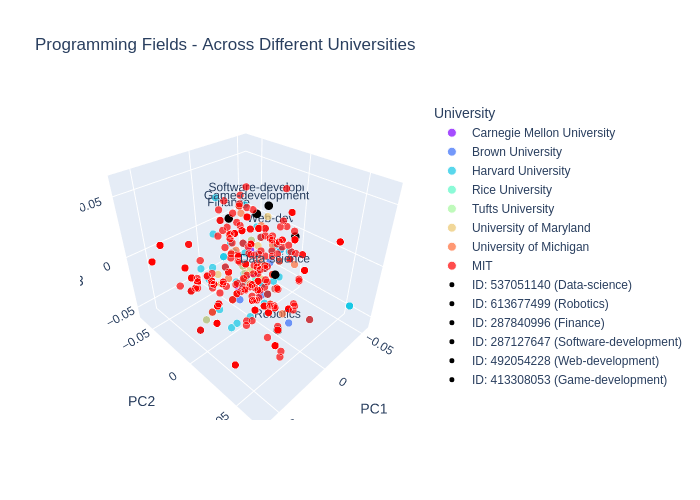

In [11]:
fig.show(renderer="png")

**Universal Sentence Encoder model**

In [12]:
USE_matrix = np.stack(combined_df_filtered["USE_field_embeddings"])

In [13]:
fig = kernel_pca_projection_by_university(combined_df_filtered, USE_matrix, "Programming Fields - Across Different Universities")

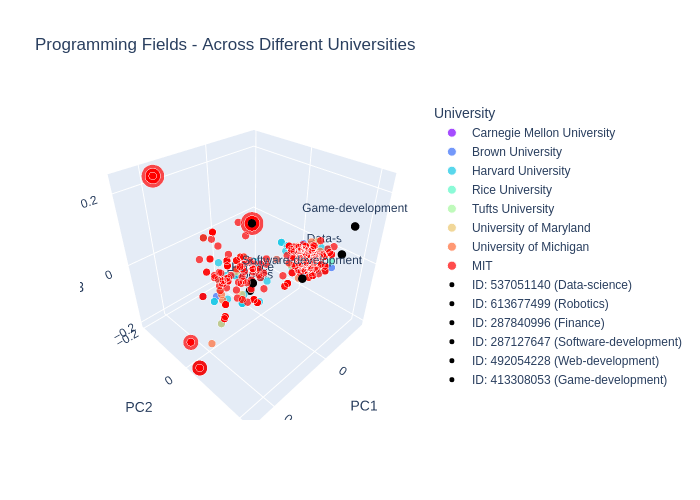

In [14]:
fig.show(renderer="png")

*The Universal Sentence Encoder model is more useful for representing the various academic/programming fields of the github projects of students across different universities. Most likely due to its ability to capture the context of the programming fields better in its encoding, whereas word2vec is useful when encoding individual words. As seen above, USE is able to put similar github projects together into large clusters, whereas word2vec isnt. However parameters of word2vec can be adjusted to see if a better result can be achieved*

*Through this visualisation, we are able to see the various respective fields of students from different universities, as well as which are common and where.*

# **Using programming languages of github project**

In [15]:
programming_languages_matrix = np.stack(combined_df_filtered['encoded_languages'])

In [16]:
fig = kernel_pca_projection_by_university(combined_df_filtered, programming_languages_matrix, "Programming Languages - Across Different Universities")

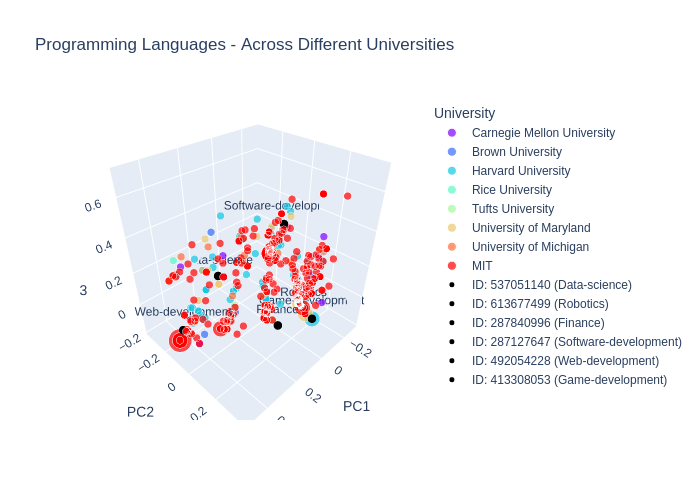

In [17]:
fig.show(renderer="png")

*Through this visualisation we can see what the most commonly used languages are, by looking at the larger clusters, as well as which projects (in which field) those languages are being applied*

# **Using complexity of github project (project size and number of languages used)**

In [20]:
#combine the two feature columns together to create matrix for kpca
project_complexity_matrix = combined_df_filtered[['repository_size_scaled', 'number_of_programming_languages_used_scaled']].values

In [21]:
fig = kernel_pca_projection_by_university(combined_df_filtered, project_complexity_matrix, "Github Project Complexities - Across Different Universities")

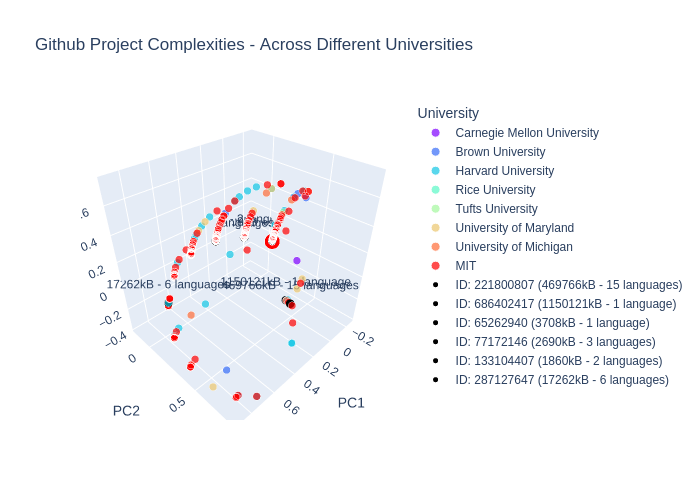

In [22]:
fig.show(renderer="png")

*Combining the two features of porject size and amount of languages used creates a clear separation. Along PCA1 there are distinct lines, denoting 1, 2, 3, etc languages used. Because most projects are found using a number of languages 1 to ~5. Since you cannot have 1.5 or 6.3 languages, the separation between the datapionts is very large.*

*Furthermore, we can see that along PCA2 there is a clear separation betwen the small sized and the large sized projects.*

*Due to these observations, we can say that it would suffice to use only 2 principal components, one which will capture the greatest variance of the number of languages used in projects, and the second will capture the variance of the project sizes.*

In [ ]:
feature_matrix = combined_df_filtered[['repository_size_scaled', 'number_of_programming_languages_used_scaled']].values

In [ ]:
fig = kernel_pca_projection_by_university_2D(combined_df_filtered, feature_matrix, "Github Project Complexities - Across Different Universities")

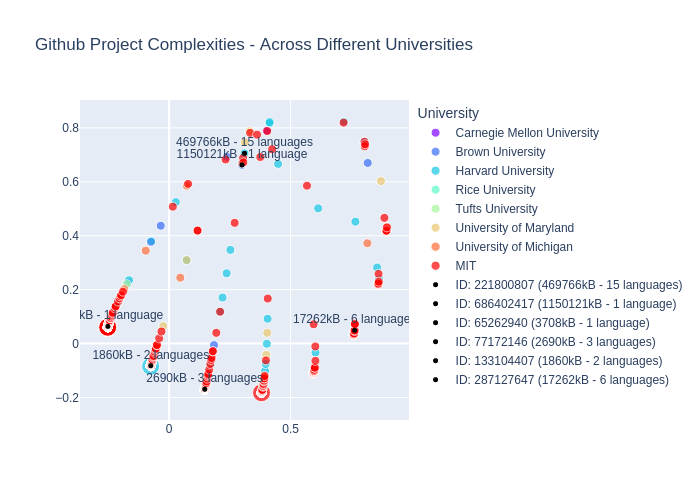

In [ ]:
fig.show(renderer="png")

*Thus we can see that 2 principal components suffice in giving a clear visualisation of the patterns within the data. We can see that the most concentrated areas are in the lower values of both component 1 and 2. Therefore, most github projects are of a small size and use few languages (1-3), with the most common type of github project being that with 1 language and small size, and the density of projects quickly decreases as programming languages and project size increase.*